# quickRocketPlot.ipynb
## Marcus Viscardi,    July 03, 2024

I want to make a quicker way to run the rocket plots from `initialPlanningAndTests.ipynb`



In [1]:
import pandas as pd
from pathlib import Path

import seaborn as sea
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

import nanoporePipelineCommon as npCommon

from icecream import ic
from datetime import datetime

def __time_formatter__():
    now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    return f"ic: {now} | > "
ic.configureOutput(prefix=__time_formatter__)
_ = ic("Imports done.")

working_dir = Path.cwd() / f"{npCommon.get_dt(for_file=True)}_rocketPlots"
try:
    working_dir.mkdir()
    _ = ic("Working dir created!", working_dir)
except FileExistsError:
    _ = ic("Working dir already exists!", working_dir)

ic: 2024-07-16 11:24:30 | > 'Imports done.'
ic: 2024-07-16 11:24:31 | > "Working dir created!": 'Working dir created!'
                            working_dir: PosixPath('/data16/marcus/scripts/nanoporePipelineScripts/deadenylationPaperFigureUpdates/240703_rocketPlots')


In [2]:
gene_id_gene_name_df = npCommon.gene_names_to_gene_ids()
gene_id_gene_name_df.head()
_ = ic("Gene ID to Gene Name conversion table loaded.")

ic: 2024-07-16 11:24:32 | > "Gene ID to Gene Name conversion table loaded.": 'Gene ID to Gene Name conversion table loaded.'


In [3]:
obj_dict = {}
pretty_name_map = {
    # The classics:
    "oldN2": "Wildtype (rep1)",
    # "oldS6": "<i>smg-6</i> (rep1)",
    # The terrible second replicates:
    # "newN2": "Wildtype (bad rep)",
    # "newS5": "<i>smg-5</i> (bad rep)",
    # "newS6": "<i>smg-6</i> (bad rep)",
    # The "better" second replicates:
    "newerN2": "Wildtype (rep2)",
    "newerS6": "<i>smg-6</i> (rep2)",
    "newerS5": "<i>smg-5</i> (rep2)",
    # The triplicates!
    "thirdN2": "Wildtype (rep3)",
    "thirdS5": "<i>smg-5</i> (rep3)",
    "thirdS6": "<i>smg-6</i> (rep3)",
    # At 25C for smg-7 (and fourth replicates in a way):
    "temp25cN2": "Wildtype (25°C)",
    "temp25cS5": "<i>smg-5</i> (25°C)",
    "temp25cS6": "<i>smg-6</i> (25°C)",
    "temp25cS7": "<i>smg-7</i> (25°C)",
}
libs_to_run = list(pretty_name_map.keys())
scatter_combos = [
    # ("oldN2", "newerN2"),
    # ("oldN2", "thirdN2"),
    ("newerN2", "thirdN2"),
    ("newerS6", "thirdS6"),
    ("newerS5", "thirdS5"),
    ("newerN2", "temp25cN2"),
    ("newerS6", "temp25cS6"),
    ("newerS5", "temp25cS5"),
    ("thirdN2", "temp25cN2"),
    ("thirdS6", "temp25cS6"),
    ("thirdS5", "temp25cS5"),
    ("temp25cN2", "temp25cS7"),
    ("temp25cS5", "temp25cS7"),
    ("temp25cS6", "temp25cS7"),
]

for lib in libs_to_run:
    print(f"\nLoading {lib}...", end="")
    obj = npCommon.NanoporeRun(run_nickname=lib)
    obj_dict[lib] = obj
    print(" Done!")
    # obj.load_mergedOnReads()


Loading oldN2... Done!
Loading 240219_mergedOnReads.parquet... Done. Loaded 701,680 rows.

Loading newerN2... Done!
Loading 230327_mergedOnReads.plusStandards.parquet... Done. Loaded 1,053,185 rows.

Loading newerS6... Done!
Loading 230403_mergedOnReads.plusStandards.parquet... Done. Loaded 1,226,144 rows.

Loading newerS5... Done!
Loading 230410_mergedOnReads.plusStandards.parquet... Done. Loaded 557,991 rows.

Loading thirdN2... Done!
Loading 230920_mergedOnReads.plusStandards.parquet... Done. Loaded 1,186,602 rows.

Loading thirdS5... Done!
Loading 230920_mergedOnReads.plusStandards.parquet... Done. Loaded 1,440,373 rows.

Loading thirdS6... Done!
Loading 230918_mergedOnReads.plusStandards.parquet... Done. Loaded 560,899 rows.

Loading temp25cN2... Done!
Loading 240701_mergedOnReads.plusStandards.parquet... Done. Loaded 522,716 rows.

Loading temp25cS5... Done!
Loading 240701_mergedOnReads.plusStandards.parquet... Done. Loaded 803,791 rows.

Loading temp25cS6... Done!
Loading 24070

In [4]:
read_df_dict = {}
gene_df_dict = {}
drop_standards = True

for lib, obj in obj_dict.items():
    print(f"Processing {lib}...")
    # read_df = obj.mergedOnReads_df.copy()
    # if drop_standards and lib not in  ['oldN2', 'newN2', 'newS5', 'newS6']:
    #     read_df = read_df.query("assignment == 'NotAStandard'")
    # read_df.qc_pass_featc = read_df.qc_pass_featc.fillna(False)
    # read_df.qc_pass_featc = read_df.qc_pass_featc.astype(bool)
    # cols_to_keep = ['read_id', 'chr_id', 'chr_pos', 'qc_pass_featc', 'gene_id', 'gene_name', 'sequence', 'cigar', 'strand', 'read_length', 'polya_length', 'qc_tag_polya']
    # if lib not in  ['oldN2', 'newN2', 'newS5', 'newS6']:
    #     cols_to_keep += ['assignment']
    # read_df_dict[lib] = read_df[cols_to_keep]
    # print(read_df.value_counts('qc_pass_featc', normalize=True))
    gene_df = obj.load_compressedOnGenes()  # Looks like the old N2 library had a read cutoff of 5 while everything else had no cutoff!!
    if drop_standards:
        gene_df = gene_df.query("gene_id != 'cerENO2'")
    gene_df_dict[lib] = gene_df

read_hits_series_dict = {}
for lib, df in gene_df_dict.items():
    print(f"Pre-cutdown:  {lib} - {df.shape[0]:,} Genes", end=" ")
    # # TODO: Eventually, I should rerun the compressing for oldN2 without the cutoff!!!
    df = df.query("read_hits >= 2")
    print(f"Post-cutdown: {lib} - {df.shape[0]:,} Genes")
    hits_series = df[['gene_id', 'read_hits']].set_index('gene_id')
    hits_series.rename(columns={'read_hits': lib}, inplace=True)
    read_hits_series_dict[lib] = hits_series

Processing oldN2...
qc_pass_featc
True     0.812672
False    0.187328
Name: proportion, dtype: float64
Loading 240219_compressedOnGenes.parquet... Done. Loaded 12,642 rows.
Processing newerN2...
qc_pass_featc
True     0.824019
False    0.175981
Name: proportion, dtype: float64
Loading 230327_compressedOnGenes.parquet... Done. Loaded 12,714 rows.
Processing newerS6...
qc_pass_featc
True     0.822437
False    0.177563
Name: proportion, dtype: float64
Loading 230403_compressedOnGenes.parquet... Done. Loaded 13,438 rows.
Processing newerS5...
qc_pass_featc
True     0.821393
False    0.178607
Name: proportion, dtype: float64
Loading 230410_compressedOnGenes.parquet... Done. Loaded 12,407 rows.
Processing thirdN2...
qc_pass_featc
True     0.832638
False    0.167362
Name: proportion, dtype: float64
Loading 230920_compressedOnGenes.parquet... Done. Loaded 12,829 rows.
Processing thirdS5...
qc_pass_featc
True     0.823629
False    0.176371
Name: proportion, dtype: float64
Loading 230920_compres

In [5]:
plot_libs = libs_to_run

plot_read_hits_table = pd.concat({lib: read_hits_series_dict[lib] for lib in plot_libs}.values(), axis=1).fillna(0)
plot_read_hits_table['avg'] = plot_read_hits_table.mean(axis=1)
plot_read_hits_table['avg_rounded'] = plot_read_hits_table['avg'].round(1)
plot_read_hits_table['std'] = plot_read_hits_table.std(axis=1)
plot_read_hits_table['std/avg'] = plot_read_hits_table['std'] / plot_read_hits_table['avg']
if 'gene_name' not in plot_read_hits_table.columns:
    gene_id_gene_name_df = npCommon.gene_names_to_gene_ids()
    plot_read_hits_table.reset_index(names='gene_id', inplace=True)
    plot_read_hits_table = plot_read_hits_table.merge(gene_id_gene_name_df, on='gene_id', how='left')
plot_read_hits_table

In [13]:
rpm_series_dict = {}
for lib, hits_series in read_hits_series_dict.items():
    print(f"{lib}: {hits_series.shape[0]:,} Genes")
    rpm_series = hits_series / hits_series.sum() * 1_000_000
    rpm_series_dict[lib] = rpm_series
plot_rpm_table = pd.concat({lib: rpm_series_dict[lib] for lib in plot_libs}.values(), axis=1).fillna(0)
if 'gene_name' not in plot_rpm_table.columns:
    gene_id_gene_name_df = npCommon.gene_names_to_gene_ids()
    plot_rpm_table.reset_index(names='gene_id', inplace=True)
    plot_rpm_table = plot_rpm_table.merge(gene_id_gene_name_df, on='gene_id', how='left')
plot_rpm_table

oldN2: 10,629 Genes
newerN2: 10,651 Genes
newerS6: 11,499 Genes
newerS5: 10,265 Genes
thirdN2: 10,767 Genes
thirdS5: 11,826 Genes
thirdS6: 8,109 Genes
temp25cN2: 9,210 Genes
temp25cS5: 11,133 Genes
temp25cS6: 11,176 Genes
temp25cS7: 9,095 Genes


,gene_id,oldN2,newerN2,newerS6,newerS5,thirdN2,thirdS5,thirdS6,temp25cN2,temp25cS5,temp25cS6,temp25cS7,gene_name,chr
0,WBGene00012730,15344.327843,36.269702,122.043464,27.145614,22.536269,30.867489,35.193211,0.000000,9.720062,76.417699,7.082755,xrn-1,II
1,WBGene00001168,9214.692119,10149.471470,10464.891717,9493.561554,10501.901498,9675.554633,10221.113915,11451.524293,9391.524106,9322.959296,13510.354988,eef-1A.1,III
2,WBGene00004478,6423.534422,6046.965233,5898.320360,5473.542897,5801.211324,5044.028263,7179.414988,5984.005369,5198.289269,5043.568143,6909.227413,rps-9,II
3,WBGene00004492,6080.359296,6071.145034,6228.240053,5629.013232,5998.403681,5274.131361,7817.920383,6293.239291,5520.995334,5441.744576,7408.561634,rps-23,IV
4,WBGene00004494,5812.858684,6228.313741,6660.086155,6574.174156,6593.736795,5901.302608,7878.251601,6990.660478,6115.863142,6284.350259,7720.202850,rps-25,IV
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14276,WBGene00020329,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.082755,bath-26,II
14277,WBGene00022571,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.082755,ZC239.13,II
14278,WBGene00194914,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.082755,F44D12.16,IV
14279,WBGene00003717,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.082755,nhr-127,V


Filtering for temp25cN2 >= 10 & temp25cS5 >= 10
Saved plot to /data16/marcus/scripts/nanoporePipelineScripts/deadenylationPaperFigureUpdates/240703_rocketPlots/temp25cN2_vs_temp25cS5_rocket_plot
Filtering for temp25cN2 >= 10 & temp25cS6 >= 10
Saved plot to /data16/marcus/scripts/nanoporePipelineScripts/deadenylationPaperFigureUpdates/240703_rocketPlots/temp25cN2_vs_temp25cS6_rocket_plot
Filtering for temp25cN2 >= 10 & temp25cS7 >= 10
Saved plot to /data16/marcus/scripts/nanoporePipelineScripts/deadenylationPaperFigureUpdates/240703_rocketPlots/temp25cN2_vs_temp25cS7_rocket_plot
Filtering for temp25cS5 >= 10 & temp25cS7 >= 10
Saved plot to /data16/marcus/scripts/nanoporePipelineScripts/deadenylationPaperFigureUpdates/240703_rocketPlots/temp25cS5_vs_temp25cS7_rocket_plot
Filtering for temp25cS6 >= 10 & temp25cS7 >= 10
Saved plot to /data16/marcus/scripts/nanoporePipelineScripts/deadenylationPaperFigureUpdates/240703_rocketPlots/temp25cS6_vs_temp25cS7_rocket_plot


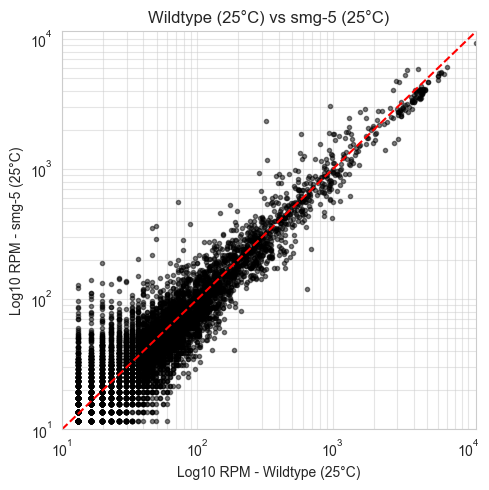

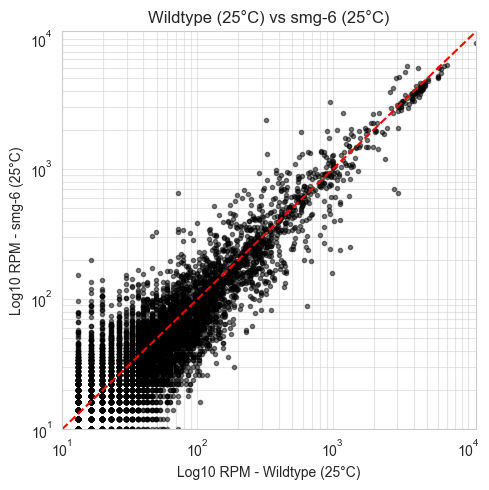

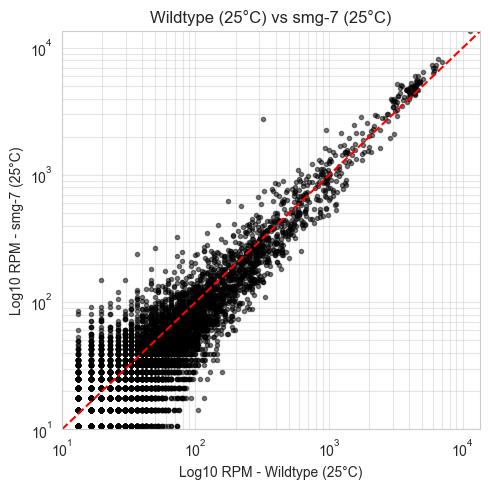

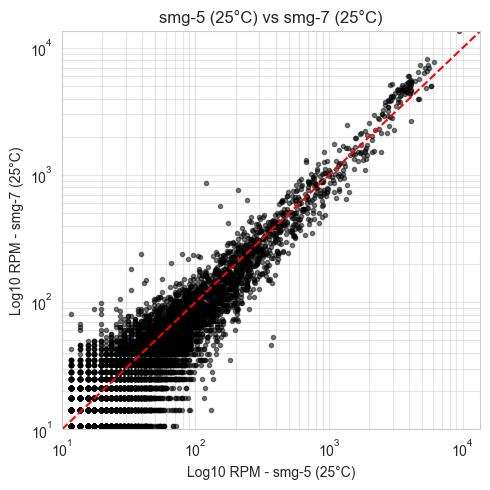

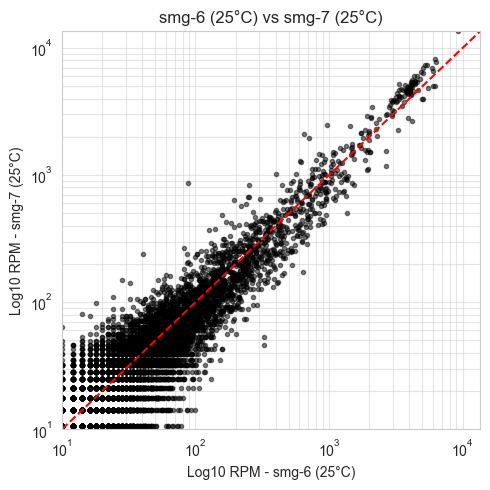

In [20]:
scatter_combos = [
    # ("oldN2", "newerN2"),
    # ("oldN2", "thirdN2"),
    # ("newerN2", "thirdN2"),
    # ("newerS6", "thirdS6"),
    # ("newerS5", "thirdS5"),
    # ("newerN2", "temp25cN2"),
    # ("newerS6", "temp25cS6"),
    # ("newerS5", "temp25cS5"),
    # ("thirdN2", "temp25cN2"),
    # ("thirdS6", "temp25cS6"),
    # ("thirdS5", "temp25cS5"),
    ("temp25cN2", "temp25cS5"),
    ("temp25cN2", "temp25cS6"),
    ("temp25cN2", "temp25cS7"),
    ("temp25cS5", "temp25cS7"),
    ("temp25cS6", "temp25cS7"),
    
]

name_map = {}
for lib, pretty_name in pretty_name_map.items():
    # I just want to remove the <i> and </i>
    simple_name = pretty_name.replace("<i>", "").replace("</i>", "")
    name_map[lib] = simple_name

def rocket_plot(x_lib, y_lib, plot_read_hits_table, ax=None, min_reads=10, name_map=name_map, save_dir: Path = None):
    try:
        print(plot_read_hits_table.columns)
        data = plot_read_hits_table.query(f"{x_lib} >= @min_reads & {y_lib} >= @min_reads")
        x = data[x_lib]
        y = data[y_lib]
    except Exception as e:
        print(f"Error: `{e}`, giving up on the plot for: {x_lib} vs {y_lib}!")
        return
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 5))
        
    ax.scatter(x=x, y=y, alpha=0.5, color='black', marker='.')

    ax.axvline(100, color='red', linestyle='--')
    ax.axhline(100, color='red', linestyle='--')

    ax.set_title(
        f"Reproducibility of gene abundance at various read count cutoffs\n{name_map[x_lib]} vs {name_map[y_lib]}")
    ax.set_xlabel(f"Log10 Reads per gene - {name_map[x_lib]}")
    ax.set_ylabel(f"Log10 Reads per gene - {name_map[y_lib]}")

    ax.set_yscale('log')
    ax.set_xscale('log')

    ax.grid(True, which="both", alpha=0.5)

    plt.tight_layout()
    if save_dir is not None and save_dir.exists():
        save_name = f"{x_lib}_vs_{y_lib}_rocket_plot"
        plt.savefig(save_dir / f"{save_name}.png", dpi=300)
        plt.savefig(save_dir / f"{save_name}.svg")
        print(f"Saved plot to {save_dir / save_name}")
    elif save_dir is not None:
        print(f"Error: Save directory does not exist: {save_dir}")
    
    if ax is None:
        plt.show()
    else:
        return ax

def rocket_plot_rpm(x_lib, y_lib, rpm_table, ax=None, min_rpm=10, name_map=name_map, save_dir: Path = None):
    try:
        print(f"Filtering for {x_lib} >= {min_rpm} & {y_lib} >= {min_rpm}")
        data = rpm_table.query(f"{x_lib} >= @min_rpm & {y_lib} >= @min_rpm")
        x = data[x_lib]
        y = data[y_lib]
    except Exception as e:
        print(f"Error: `{e}`, giving up on the plot for: {x_lib} vs {y_lib}!")
        return
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 5))
        
    ax.scatter(x=x, y=y, alpha=0.5, color='black', marker='.')
    # Let's add a diagonal line!
    ax.plot([min_rpm, 1_000_000], [min_rpm, 1_000_000], color='red', linestyle='--')
    x_y_lim = max(x.max(), y.max())
    ax.set_xlim(min_rpm, x_y_lim)
    ax.set_ylim(min_rpm, x_y_lim)

    ax.set_title(f"{name_map[x_lib]} vs {name_map[y_lib]}")
    ax.set_xlabel(f"Log10 RPM - {name_map[x_lib]}")
    ax.set_ylabel(f"Log10 RPM - {name_map[y_lib]}")

    ax.set_yscale('log')
    ax.set_xscale('log')

    ax.grid(True, which="both", alpha=0.5)

    plt.tight_layout()
    if save_dir is not None and save_dir.exists():
        save_name = f"{x_lib}_vs_{y_lib}_rocket_plot"
        plt.savefig(save_dir / f"{save_name}.png", dpi=300)
        plt.savefig(save_dir / f"{save_name}.svg")
        print(f"Saved plot to {save_dir / save_name}")
    elif save_dir is not None:
        print(f"Error: Save directory does not exist: {save_dir}")
    
    if ax is None:
        plt.show()
    else:
        return ax

for x_lib, y_lib in scatter_combos:
    rocket_plot_rpm(x_lib, y_lib, plot_rpm_table, save_dir=working_dir)